# PyGeM

## Tutorial 5: Deformation of an object stored into file

In the present tutorial, we are going to show the fundamental steps to compute in order to deform a given object stored in a given file.

To achieve this, we basically need a parser for extracting from the file all geometrical information (typically the nodes coordinates and the topology), then deforming such nodes with one of the **PyGeM** deformation techniques.
Here we show a simple `FFD` applied to a `.vtp` and to an `.stl` files. To deal with such files, we employ the [Smithers](https://github.com/mathLab/Smithers) package, a utilities toolbox that allows for an easy manipulation of several file formats.

As usually, at the beginning we import all the modules we need.

In [1]:
import sys
import platform
import subprocess
import numpy as np

print(f"Python Version: {sys.version}")
print(f"Platform: {sys.platform}")
print(f"System: {platform.system()} {platform.release()}")

try:
    import pygem
    print(f"PyGeM version: {pygem.__version__}")
except ImportError:
    print(f"PyGeM not found. Installing...")
    # Installing from local source. It can be replaced with github installation once pushed and merged.
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-e", ".[tut]"])
    import pygem
    print(f"PyGeM version: {pygem.__version__}")

try:
    from smithers import io
except ImportError:
    print("smithers not found. Installing from GitHub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/mathLab/Smithers.git"])
    from smithers import io

np.random.seed(42)
get_ipython().run_line_magic('matplotlib', 'inline')

from pygem import FFD

Python Version: 3.9.25 (main, Nov  3 2025, 22:33:05) 
[GCC 11.2.0]
Platform: linux
System: Linux 6.12.0-55.41.1.el10_0.x86_64


PyGeM version: 2.0.0


For visualization purpose, we also implement a small function that shows the object parsed with **Smithers**.

In [2]:
def plot(data, color=None):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.pyplot as plt

    if color is None:
        color = (0, 0, 1, 0.1)
    fig = plt.figure(figsize=(16, 10))

    verts = [data["points"][cell] for cell in data["cells"]]
    ax = fig.add_subplot(111, projection="3d")
    faces = Poly3DCollection(verts, linewidths=1, edgecolors="k")
    faces.set_facecolor(color)

    ax.add_collection3d(faces)
    ax.set_xlim3d(-0.8, 0.8)
    ax.set_ylim3d(-0.8, 0.8)
    ax.set_zlim3d(-0.8, 0.8)
    ax.set_aspect("equal", "box")

    plt.show()

### Deformation of the VTP file

First of all, we need a `.vtp` file: we download a simple cube and we open it.

--2025-11-12 16:15:11--  https://raw.githubusercontent.com/mathLab/Smithers/master/tests/test_datasets/cube.vtp


Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


HTTP request sent, awaiting response... 

200 OK
Length: 2498 (2.4K) [text/plain]
Saving to: ‘cube.vtp’

cube.vtp            100%[===================>]   2.44K  --.-KB/s    in 0s      

2025-11-12 16:15:11 (82.5 MB/s) - ‘cube.vtp’ saved [2498/2498]



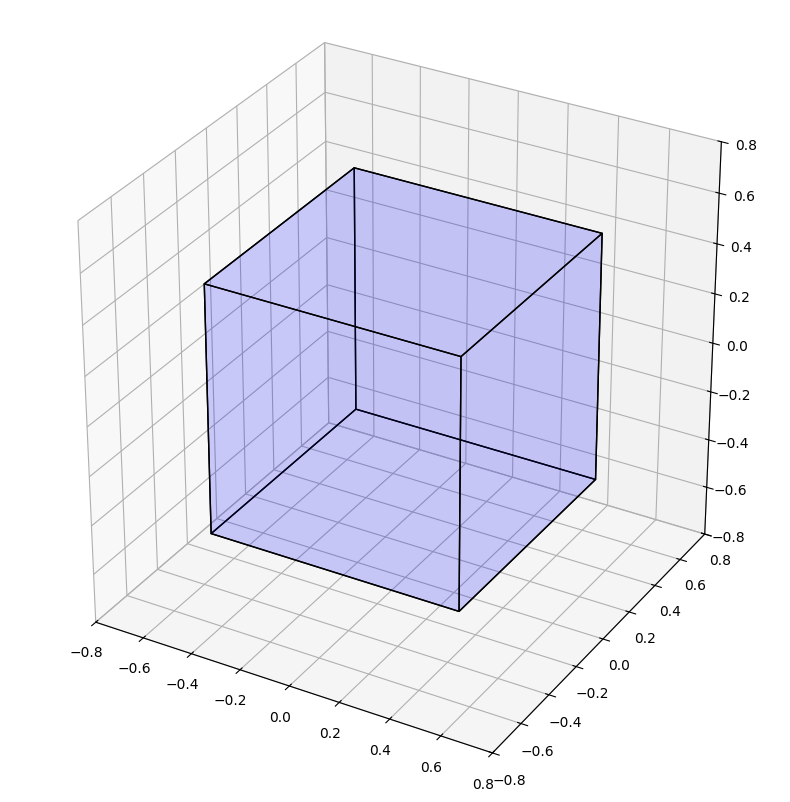

In [3]:
!rm -rf cube.vtp
!wget https://raw.githubusercontent.com/mathLab/Smithers/master/tests/test_datasets/cube.vtp
vtp_filename = "cube.vtp"

vtp_content = io.VTPHandler.read(vtp_filename)
plot(vtp_content)

We can now instantiate a new `FFD` object, setting position and lenght of the lattice of points as well as their displacements. We present here a very simple deformation, moving just one control points, but of course it is possible to change the `FFD` settings according to needed. We also remark that of course any other deformation (by **PyGeM**) can be used!

In [4]:
ffd = FFD()
ffd.origin_box = np.array([-0.6, -0.6, -0.6])
ffd.box_length = np.array([1.2, 1.2, 1.2])

ffd.array_mu_x[1, 1, 1] += 1.5

Now the actual deformation: the points of our object are morphed through the `ffd` and the new coordinates are replaced to the older one.

In [5]:
vtp_content["points"] = ffd(vtp_content["points"])

Here a visual test to see the final outcome!

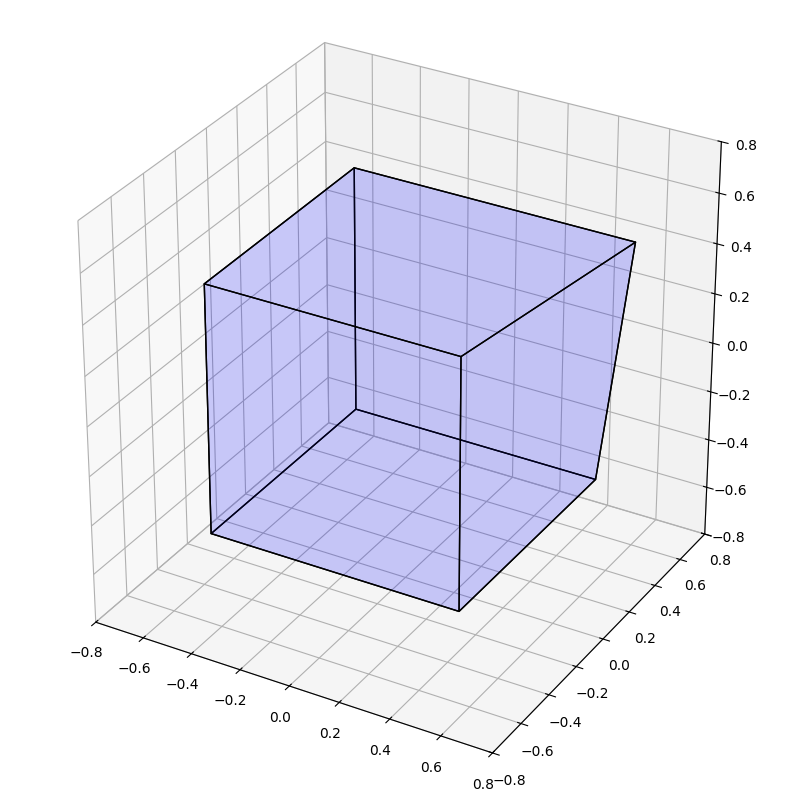

In [6]:
plot(vtp_content)

Of course, the deformed object is still contained within the `vtp_content` dictionary. To save it into a new file, we just need to use again the `VTPHandler` by **Smithers**.

In [7]:
io.VTPHandler.write("deform_cube.vtp", vtp_content)

Pretty easy, isn't?

### Deformation of an STL file
Here we basically replicate (in a more compress way) the previous steps in order to deform an object stored in an STL file. As before, we deal with a simple cube.

In [8]:
!rm -rf cube.stl
!wget https://raw.githubusercontent.com/mathLab/Smithers/master/tests/test_datasets/cube.stl
stl_filename = "cube.stl"

stl_content = io.STLHandler.read(stl_filename)
stl_content["points"] = ffd(stl_content["points"])
io.STLHandler.write("deform_cube.stl", stl_content)

--2025-11-12 16:15:12--  https://raw.githubusercontent.com/mathLab/Smithers/master/tests/test_datasets/cube.stl


Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


HTTP request sent, awaiting response... 

200 OK
Length: 1509 (1.5K) [text/plain]
Saving to: ‘cube.stl’

cube.stl            100%[===================>]   1.47K  --.-KB/s    in 0s      

2025-11-12 16:15:12 (49.0 MB/s) - ‘cube.stl’ saved [1509/1509]



We can now plot the content of the original file and the deformed one, showing the altered geometry.

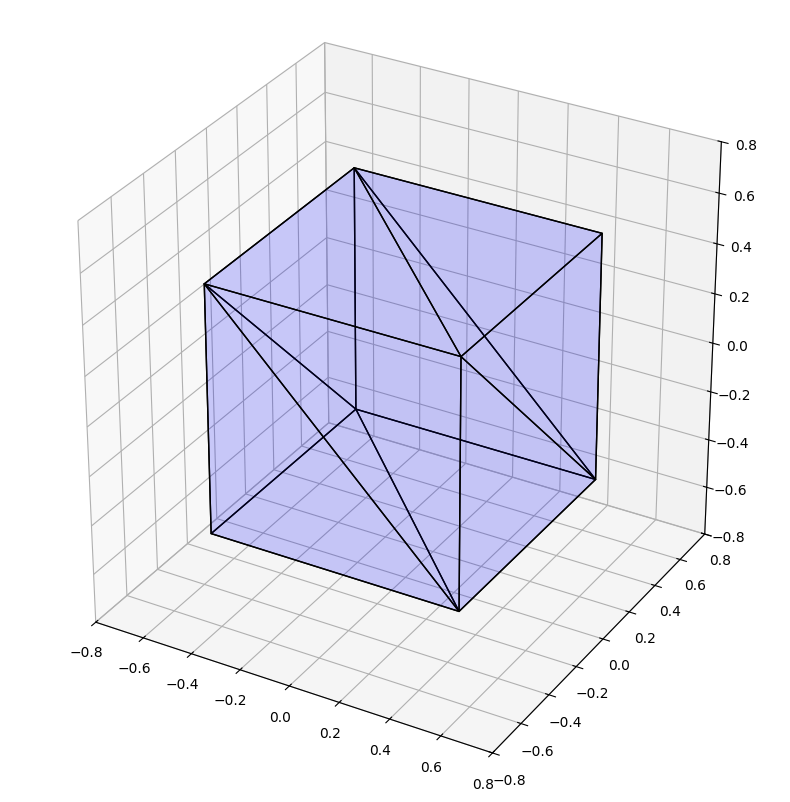

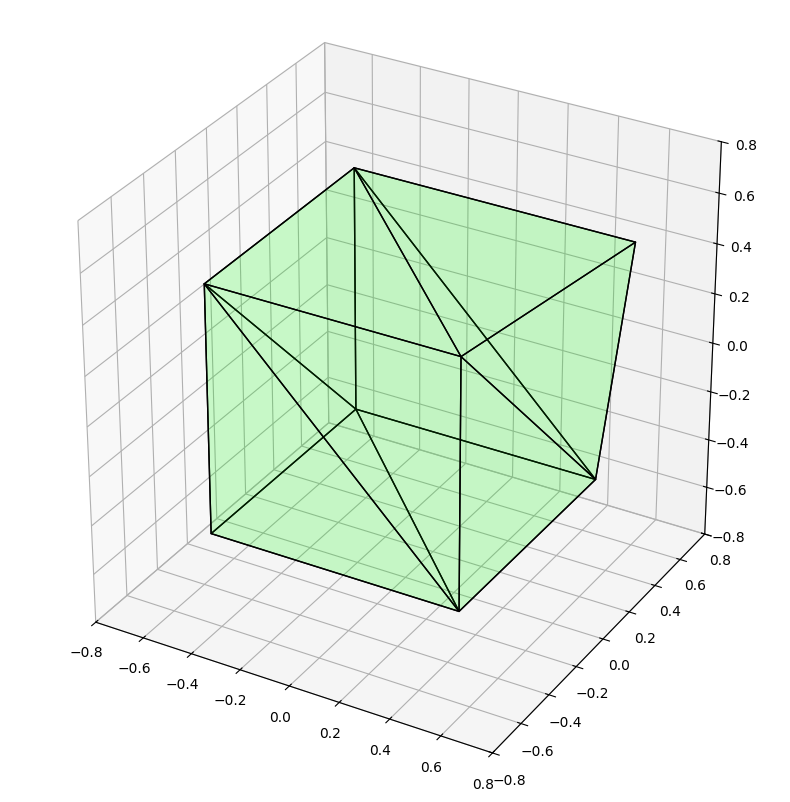

In [9]:
plot(io.STLHandler.read("cube.stl"))
plot(io.STLHandler.read("deform_cube.stl"), (0, 1, 0, 0.1))

### Other file formats?

`vtp` and `stl` are common formats in the scientific community, but of course there are many more available. What if you have to deform a different file?
As first step, we suggest to check the [Smithers](https://github.com/mathLab/Smithers) documentation looking for the handler for the file format in hand.
If the latter is not implemented yet, you can write by your own the parser (and hopefully make a Pull-Request to **Smithers** to make your improvement also available for other users) or just use some third-party libraries to extract the node coordinates!
Happy deformations!